In [1]:
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import random
import seaborn as sns
from pathlib import Path
import statsmodels.formula.api as smf

### Aux

In [2]:
def load_pkl(file_path):
    return pd.read_pickle(file_path)

In [3]:
def load_all_subjects(folder):
    all_dfs = []
    for fname in os.listdir(folder):
        if fname.endswith(".pkl"):
            path = os.path.join(folder, fname)
            df = pd.read_pickle(path)
            df["subj"] = fname.replace(".pkl", "")
            all_dfs.append(df)
    return pd.concat(all_dfs, ignore_index=True)

In [4]:
def average_metrics_over_subjects(df):
    # metricas en las que 0 significa que no hubo fijacion -> van a NAN para que no se tengan en cuenta
    duration_metrics = ["FFD", "SFD", "FPRT", "RPD", "TFD", "RRT", "SPRT"]
    df[duration_metrics] = df[duration_metrics].replace(0, np.nan)
    # sacar las excluded
    #df = df[df["excluded"] == False]
    # hacer la media por id en oracion, id de palabra y palabra
    mean_df = df.groupby(["sentence_idx", "word_idx", "word"], as_index=False).mean(numeric_only=True)
    mean_df = mean_df.fillna(0)
    return mean_df

In [5]:
def plot_correlation(df1, df2, metric="FFD"):
    """
    Visualiza la correlación entre la misma métrica en dos DataFrames.
    Ambos df deben estar alineados por (sentence_idx, word_idx).
    """
    # Unir por claves de posición
    merged = pd.merge(df1, df2, on=["sentence_idx", "word_idx"], suffixes=("_sim", "_hum"))

    x = merged[f"{metric}_sim"]
    y = merged[f"{metric}_hum"]

    # Calcular correlación
    corr_value = x.corr(y)

    # Scatterplot con línea de regresión
    plt.figure(figsize=(6,6))
    sns.regplot(x=x, y=y, scatter_kws={"alpha":0.5})
    plt.xlabel(f"{metric} simulador (OB1)")
    plt.ylabel(f"{metric} humanos")
    plt.title(f"Correlación {metric}: r = {corr_value:.3f}")
    plt.grid(alpha=0.3)
    plt.show()

    return corr_value

In [6]:
def plot_2d_hist_metric(
    df_sim, df_hum, metric="FFD",
    keys=("sentence_idx", "word_idx"),
    bins=25, drop_zeros=True, log_counts=True
):
    """
    Heatmap 2D (histograma conjunto) entre simulador (X) y humanos (Y).

    Parámetros
    ----------
    df_sim : DataFrame (simulador OB1)
    df_hum : DataFrame (humanos)
    metric : str, métrica a graficar (ej. "FFD")
    keys   : columnas para alinear ambos DataFrames
    bins   : número de bins del histograma
    drop_zeros : si True, descarta valores 0
    log_counts : si True, aplica log(1+count) para mejorar contraste
    """

    # 1) Unir por claves comunes
    merged = pd.merge(
        df_sim[list(keys) + [metric]].rename(columns={metric: f"{metric}_sim"}),
        df_hum[list(keys) + [metric]].rename(columns={metric: f"{metric}_hum"}),
        on=list(keys),
        how="inner"
    )

    # 2) Extraer y limpiar (X = simulación, Y = humanos)
    x = merged[f"{metric}_sim"].astype(float).values
    y = merged[f"{metric}_hum"].astype(float).values

    m = np.isfinite(x) & np.isfinite(y)
    if drop_zeros:
        m &= (x > 0) & (y > 0)

    x, y = x[m], y[m]
    if x.size == 0 or y.size == 0:
        raise ValueError("No hay datos válidos para graficar (revisá NaN/0 y la alineación).")

    # 3) Histograma 2D
    H, xedges, yedges = np.histogram2d(x, y, bins=bins)

    # 4) Escala opcional logarítmica
    Hplot = np.log1p(H) if log_counts else H

    # 5) Plot
    extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
    plt.figure(figsize=(6, 5))
    im = plt.imshow(Hplot.T, origin="lower", extent=extent, aspect="auto")
    plt.xlabel(f"{metric} Simulador (OB1)")
    plt.ylabel(f"{metric} Humanos")
    cbar = plt.colorbar(im)
    cbar.set_label("count (log1p)" if log_counts else "count")

    # Línea y=x como referencia
    lo = min(extent[0], extent[2]); hi = max(extent[1], extent[3])
    plt.plot([lo, hi], [lo, hi], "--", linewidth=1, color="white")

    plt.title(f"Densidad conjunta {metric}")
    plt.tight_layout()
    plt.show()


In [7]:
metrics = ["FFD","SFD","FPRT","RPD","TFD","RRT","SPRT","FC","RC","LS","RR"]
compare = pd.DataFrame({
    "metric": metrics,
    "1 Sim vs All mean": [None] * len(metrics),
    "1 Sim vs Individual mean": [None] * len(metrics),
    "All Sim vs All mean": [None] * len(metrics)
})

In [8]:
def fit_mixed_model(metric, df):
    """
    Modelo lineal mixto para la metrica.
    Formula: metric_Ob1 ~ metric_subj + (1|subj) + (1|word)
    """
    # Model
    model = smf.mixedlm(
        f"{metric}_Ob1 ~ {metric}_c",
        data=df,
        groups=df["subj"],                     # random intercept + slope by subj
        re_formula=f"~ {metric}_c",            # add random slope for human metric
        vc_formula={"word": "0 + C(word)"}     # random intercept by word
    ).fit(reml=True)


    print(f"Model fitted for {metric}")
    print(model.summary())

    return model, df


In [9]:
def plot_mixed_model(metric, df, model, output_dir="mixed_model_results"):
    """
    Generates and saves two plots:
        (A) Predicted vs Observed
        (B) Human vs Simulation by subject
    """
    output_dir = Path(output_dir)
    output_dir.mkdir(exist_ok=True)

    # Predictions
    df["predicted"] = model.predict(df)

    # ---- Plot A: Predicted vs Observed ----
    plt.figure(figsize=(6,6))
    sns.scatterplot(x=f"{metric}_Ob1", y="predicted", data=df, alpha=0.5)
    lims = [df[f"{metric}_Ob1"].min(), df[f"{metric}_Ob1"].max()]
    plt.plot(lims, lims, "r--", label="Perfect prediction")
    plt.xlabel(f"Observed {metric}_Ob1 (simulation)")
    plt.ylabel("Predicted by mixed model")
    plt.legend()
    plt.title(f"{metric}: Predicted vs Observed")
    plt.tight_layout()
    plt.savefig(output_dir / f"{metric}_pred_vs_obs.png", dpi=150)
    plt.close()

    # ---- Plot B: by Subject ----
    plt.figure(figsize=(8,6))
    sns.scatterplot(x=metric, y=f"{metric}_Ob1", hue="subj", data=df, alpha=0.4)
    sns.lineplot(
        x=metric, y="predicted", data=df,
        color="black", linewidth=2, label="Mixed model average fit"
    )
    plt.title(f"{metric}_Ob1 vs {metric} (by subject)")
    plt.xlabel(f"Human {metric}")
    plt.ylabel(f"Simulation {metric}_Ob1")
    plt.legend()
    plt.tight_layout()
    plt.savefig(output_dir / f"{metric}_by_subject.png", dpi=150)
    plt.close()

    print(f"Saved plots for {metric} → {output_dir}")

## Correlacion

### Un sujeto de cada uno

In [10]:
sujetos = ['CE01', 'DG01', 'FD01', 'LCC01', 'LS01', 'LZ01', 'MA02', 'MC01', 'RZ01', 'SB01', 'TM01']
sujeto1 = random.choice(sujetos)
sujeto2 = random.choice(sujetos)

In [11]:
# un sujeto original
data_og = load_pkl(f"results_og_all/measures/Axolotl/{sujeto1}.pkl")
print(data_og.shape)
data_og.head(10)

(1975, 19)


,subj,screen,word_idx,word,sentence_idx,sentence_pos,screen_pos,excluded,FFD,SFD,FPRT,RPD,TFD,RRT,SPRT,FC,RC,LS,RR
0,MA02,1,0,hubo,0,0,0,True,0,0,0,0,0,0,0,0,0,NaN,NaN
1,MA02,1,1,un,0,1,1,False,0,0,0,0,0,0,0,0,0,1.000000,0.000000
2,MA02,1,2,tiempo,0,2,2,False,0,0,0,0,0,0,0,0,0,1.000000,0.000000
3,MA02,1,3,en,0,3,3,False,127,127,127,0,127,-127,0,1,0,0.454545,0.000000
4,MA02,1,4,que,0,4,4,False,0,0,0,0,0,0,0,0,0,0.727273,0.000000
5,MA02,1,5,yo,0,5,5,False,165,165,165,0,165,-165,0,1,0,0.272727,0.090909
6,MA02,1,6,pensaba,0,6,6,False,0,0,0,0,0,0,0,0,0,0.818182,0.181818
7,MA02,1,7,mucho,0,7,7,False,83,83,83,0,83,-83,0,1,0,0.272727,0.090909
8,MA02,1,8,en,0,8,8,False,0,0,0,141,141,141,141,1,1,0.636364,0.181818
9,MA02,1,9,los,0,9,9,False,240,240,240,0,240,-240,0,1,0,0.090909,0.181818


In [12]:
# un sujeto de ob1
data_ob1 = load_pkl(f"results_ob1_normal_1/measures/Axolotl/DG01.pkl")
print(data_ob1.shape)
data_ob1.head(10)

(1975, 19)


,subj,screen,word_idx,word,sentence_idx,sentence_pos,screen_pos,excluded,FFD,SFD,FPRT,RPD,TFD,RRT,SPRT,FC,RC,LS,RR
0,DG01,1,0,hubo,0,0,0,True,0,0,0,0,0,0,0,0,0,NaN,NaN
1,DG01,1,1,un,0,1,1,False,0,0,0,0,0,0,0,0,0,1.0,0.0
2,DG01,1,2,tiempo,0,2,2,False,0,0,0,0,0,0,0,0,0,1.0,0.0
3,DG01,1,3,en,0,3,3,False,0,0,0,0,0,0,0,0,0,1.0,0.0
4,DG01,1,4,que,0,4,4,False,0,0,0,0,0,0,0,0,0,1.0,0.0
5,DG01,1,5,yo,0,5,5,False,225,0,425,0,425,-425,0,2,0,0.0,0.0
6,DG01,1,6,pensaba,0,6,6,False,0,0,0,0,0,0,0,0,0,1.0,0.0
7,DG01,1,7,mucho,0,7,7,False,175,175,175,0,175,-175,0,1,0,0.0,0.0
8,DG01,1,8,en,0,8,8,False,0,0,0,0,0,0,0,0,0,1.0,0.0
9,DG01,1,9,los,0,9,9,False,250,250,250,0,250,-250,0,1,0,0.0,0.0


In [13]:
np.corrcoef(data_og['FFD'].values, data_ob1['FFD'].values)

array([[1.        , 0.44991932],
       [0.44991932, 1.        ]])

### Correlacion de todos los sujetos originales vs uno de OB1

In [14]:
# medias de todos los sujetos originales
folder_original = "results_og_all/measures/Axolotl"
all_data_original = load_all_subjects(folder_original)
mean_metrics_original = average_metrics_over_subjects(all_data_original)
# ob1
folder_ob1 = "results_ob1_normal_1/measures/Axolotl"
all_data_ob1 = load_all_subjects(folder_ob1)
mean_metrics_ob1 = average_metrics_over_subjects(all_data_ob1)

In [15]:
mean_metrics_ob1

,sentence_idx,word_idx,word,screen,sentence_pos,screen_pos,excluded,FFD,SFD,FPRT,RPD,TFD,RRT,SPRT,FC,RC,LS,RR
0,0,0,hubo,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0,1,un,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,0,2,tiempo,1.0,2.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,0,3,en,1.0,3.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,0,4,que,1.0,4.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1970,106,1970,todo,24.0,29.0,7.0,0.0,225.0,225.0,225.0,0.0,225.0,-225.0,0.0,1.0,0.0,0.0,0.0
1971,106,1971,esto,24.0,30.0,8.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1972,106,1972,sobre,24.0,31.0,9.0,0.0,200.0,200.0,200.0,0.0,200.0,-200.0,0.0,1.0,0.0,0.0,0.0
1973,106,1973,los,24.0,32.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [16]:
np.corrcoef(mean_metrics_original['FFD'].values, mean_metrics_ob1['FFD'].values)

array([[1.        , 0.47484193],
       [0.47484193, 1.        ]])

In [17]:
corrs = pd.DataFrame(["FFD","SFD","FPRT","RPD","TFD","RRT","SPRT","FC","RC","LS","RR"])
for metric in metrics:
    original = mean_metrics_original[metric].values
    ob1 = mean_metrics_ob1[metric].values
    corr = np.corrcoef(original, ob1)
    print(f"{metric}:", round(corr[0,1],3))
    compare.loc[compare['metric'] == metric, '1 Sim vs All mean'] = round(corr[0,1],3)
    

FFD: 0.475
SFD: 0.315
FPRT: 0.447
RPD: 0.231
TFD: 0.5
RRT: 0.158
SPRT: 0.231
FC: 0.545
RC: 0.271
LS: 0.564
RR: 0.24


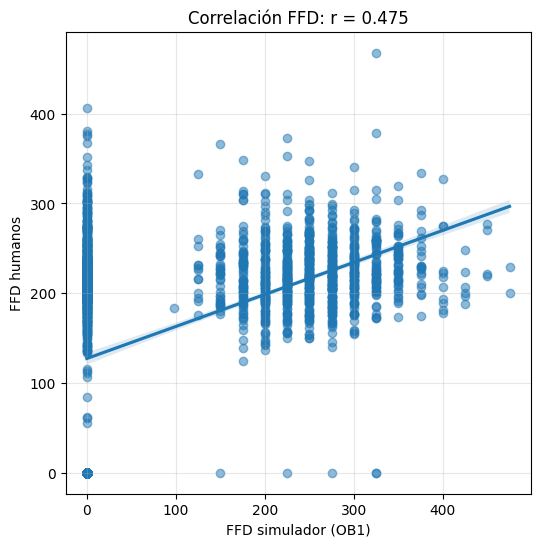

Correlación: 0.47484192666628955


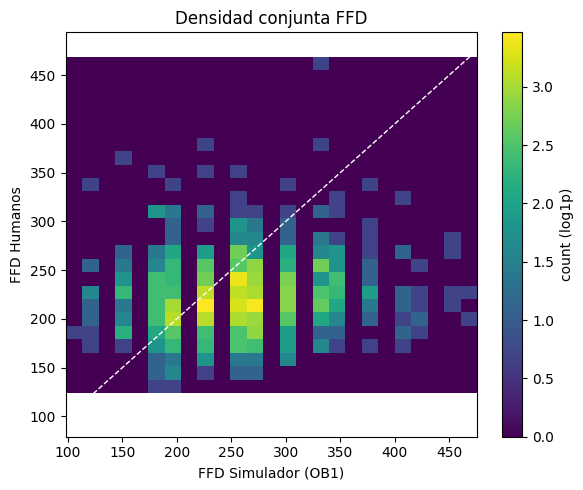

In [18]:
metric = "FFD"
r = plot_correlation(mean_metrics_ob1, mean_metrics_original, metric = metric)
print("Correlación:", r)
plot_2d_hist_metric(mean_metrics_ob1, mean_metrics_original, metric = metric, bins=25)

### OB1 vs cada sujeto (individual)

In [19]:
# medias de todos los sujetos originales
folder_original = "results_og_all/measures/Axolotl"
all_data_original = load_all_subjects(folder_original)
all_data_original = all_data_original.fillna(0)
# ob1
folder_ob1 = "results_ob1_normal_1/measures/Axolotl"
all_data_ob1 = load_all_subjects(folder_ob1)
all_data_ob1 = all_data_ob1.fillna(0)

In [20]:
individual_corr = pd.DataFrame()
metrics = ["FFD","SFD","FPRT","RPD","TFD","RRT","SPRT","FC","RC","LS","RR"]
individual_corr['subj'] = all_data_original['subj'].unique()
for subj in individual_corr['subj']:
    df_subject = all_data_original[all_data_original['subj'] == subj]
    for metric in metrics:
        original = df_subject[metric].values
        ob1 = all_data_ob1[metric].values
        corr = np.corrcoef(original, ob1)[0,1]
        individual_corr.loc[individual_corr['subj'] == subj, metric] = corr

In [21]:
individual_corr

,subj,FFD,SFD,FPRT,RPD,TFD,RRT,SPRT,FC,RC,LS,RR
0,SB01,0.297562,0.147159,0.302870,0.074209,0.347349,0.021857,0.074209,0.346140,0.079860,0.565683,0.234799
1,MA02,0.449919,0.238473,0.383637,0.112247,0.387853,0.127215,0.112247,0.382525,0.073709,0.565683,0.237227
2,CE01,0.460064,0.197115,0.424983,0.123672,0.370917,0.148738,0.123672,0.376097,0.111431,0.564281,0.241029
3,FD01,0.458991,0.143604,0.380299,0.145287,0.356522,0.043172,0.145287,0.370027,0.154575,0.566202,0.245641
4,TM01,0.522441,0.252571,0.487261,0.098064,0.469222,0.166053,0.098064,0.463215,0.100489,0.565795,0.241024
5,LS01,0.395897,0.208342,0.370371,0.043124,0.304881,0.082720,0.043124,0.327248,0.055793,0.565683,0.236991
6,LCC01,0.442305,0.242073,0.386291,0.108246,0.382003,0.116682,0.108246,0.406460,0.139195,0.566247,0.243665
7,LZ01,0.406945,0.121771,0.320898,0.129853,0.316205,0.032050,0.129853,0.342127,0.138078,0.565840,0.241250
8,MC01,0.402104,0.121899,0.371408,0.144835,0.356508,0.024967,0.144835,0.352956,0.120808,0.563875,0.236887
9,RZ01,0.438311,0.195473,0.388275,0.084358,0.365175,-0.001817,0.084358,0.368528,0.072053,0.566090,0.241634


In [22]:
for col in individual_corr.columns[1:]:
    mean_val = individual_corr[col].mean()
    print(f"{col}: {round(mean_val,3)}")
    compare.loc[compare['metric'] == col, '1 Sim vs Individual mean'] = round(mean_val,3)

FFD: 0.424
SFD: 0.183
FPRT: 0.382
RPD: 0.124
TFD: 0.374
RRT: 0.082
SPRT: 0.124
FC: 0.382
RC: 0.125
LS: 0.566
RR: 0.24


### Correlacion de todos los sujetos originales vs todos de OB1

In [23]:
# medias de todos los sujetos originales
folder_original = "results_og_all/measures/Axolotl"
all_data_original = load_all_subjects(folder_original)
mean_metrics_original = average_metrics_over_subjects(all_data_original)
# ob1
folder_ob1 = "results_ob1_normal_11/measures/Axolotl"
all_data_ob1 = load_all_subjects(folder_ob1)
mean_metrics_ob1 = average_metrics_over_subjects(all_data_ob1)

In [24]:
corrs = pd.DataFrame(["FFD","SFD","FPRT","RPD","TFD","RRT","SPRT","FC","RC","LS","RR"])
metrics = ["FFD","SFD","FPRT","RPD","TFD","RRT","SPRT","FC","RC","LS","RR"]
for metric in metrics:
    original = mean_metrics_original[metric].values
    ob1 = mean_metrics_ob1[metric].values
    corr = np.corrcoef(original, ob1)
    print(f"{metric}:", round(corr[0,1],3))
    compare.loc[compare['metric'] == metric, 'All Sim vs All mean'] = round(corr[0,1],3)

FFD: 0.706
SFD: 0.578
FPRT: 0.678
RPD: 0.331
TFD: 0.62
RRT: 0.195
SPRT: 0.331
FC: 0.692
RC: 0.294
LS: 0.69
RR: 0.304


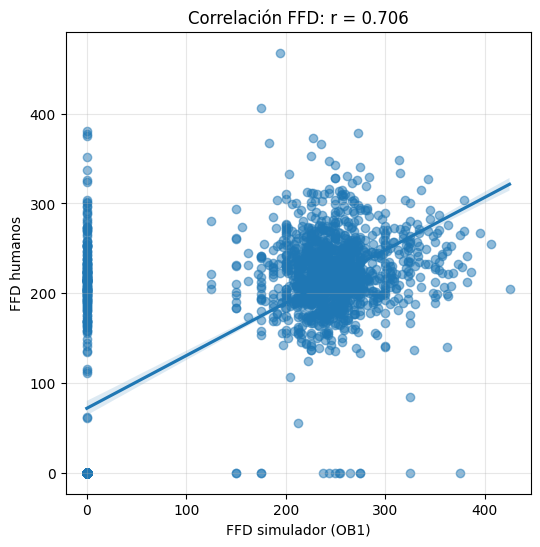

Correlación: 0.706446802082881


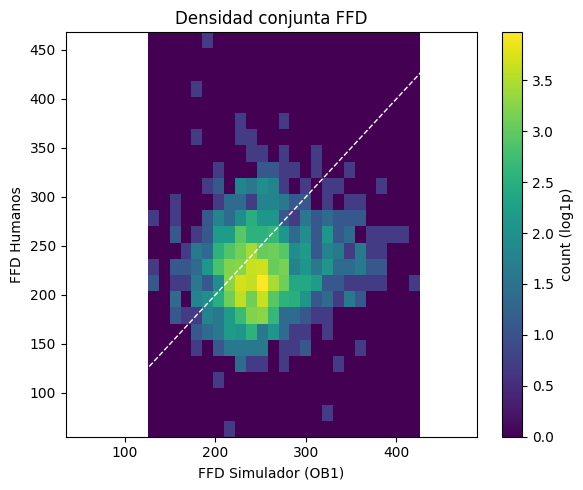

In [25]:
metric = "FFD"
r = plot_correlation(mean_metrics_ob1, mean_metrics_original, metric = metric)
print("Correlación:", r)
plot_2d_hist_metric(mean_metrics_ob1, mean_metrics_original, metric = metric, bins=25)

### Comparacion

In [26]:
compare

,metric,1 Sim vs All mean,1 Sim vs Individual mean,All Sim vs All mean
0,FFD,0.475,0.424,0.706
1,SFD,0.315,0.183,0.578
2,FPRT,0.447,0.382,0.678
3,RPD,0.231,0.124,0.331
4,TFD,0.5,0.374,0.62
5,RRT,0.158,0.082,0.195
6,SPRT,0.231,0.124,0.331
7,FC,0.545,0.382,0.692
8,RC,0.271,0.125,0.294
9,LS,0.564,0.566,0.69


## Modelo Lineal Mixto

In [27]:
# subjects
folder_original = "results_og_all/measures/Axolotl"
all_data_original = load_all_subjects(folder_original)
all_data_original['word_id'] = all_data_original['screen'].astype(str) + '-' + all_data_original['word_idx'].astype(str)
# ob1
folder_ob1 = "results_ob1_normal_1/measures/Axolotl"
all_data_ob1 = load_all_subjects(folder_ob1)
all_data_ob1['word_id'] = all_data_ob1['screen'].astype(str) + '-' + all_data_ob1['word_idx'].astype(str)

display(all_data_original)
display(all_data_ob1)

,subj,screen,word_idx,word,sentence_idx,sentence_pos,screen_pos,excluded,FFD,SFD,FPRT,RPD,TFD,RRT,SPRT,FC,RC,LS,RR,word_id
0,SB01,1,0,hubo,0,0,0,True,0,0,0,0,0,0,0,0,0,NaN,NaN,1-0
1,SB01,1,1,un,0,1,1,False,0,0,0,0,0,0,0,0,0,1.000000,0.000000,1-1
2,SB01,1,2,tiempo,0,2,2,False,0,0,0,0,0,0,0,0,0,1.000000,0.000000,1-2
3,SB01,1,3,en,0,3,3,False,0,0,0,0,0,0,0,0,0,0.454545,0.000000,1-3
4,SB01,1,4,que,0,4,4,False,0,0,0,0,0,0,0,0,0,0.727273,0.000000,1-4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21720,DG01,24,1970,todo,106,29,7,False,177,0,369,91,460,-278,91,3,1,0.181818,0.363636,24-1970
21721,DG01,24,1971,esto,106,30,8,True,0,0,0,0,0,0,0,0,0,NaN,NaN,24-1971
21722,DG01,24,1972,sobre,106,31,9,False,205,205,205,0,205,-205,0,1,0,0.090909,0.272727,24-1972
21723,DG01,24,1973,los,106,32,10,False,221,221,221,0,221,-221,0,1,0,0.545455,0.181818,24-1973


,subj,screen,word_idx,word,sentence_idx,sentence_pos,screen_pos,excluded,FFD,SFD,FPRT,RPD,TFD,RRT,SPRT,FC,RC,LS,RR,word_id
0,DG01,1,0,hubo,0,0,0,True,0,0,0,0,0,0,0,0,0,NaN,NaN,1-0
1,DG01,1,1,un,0,1,1,False,0,0,0,0,0,0,0,0,0,1.0,0.0,1-1
2,DG01,1,2,tiempo,0,2,2,False,0,0,0,0,0,0,0,0,0,1.0,0.0,1-2
3,DG01,1,3,en,0,3,3,False,0,0,0,0,0,0,0,0,0,1.0,0.0,1-3
4,DG01,1,4,que,0,4,4,False,0,0,0,0,0,0,0,0,0,1.0,0.0,1-4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1970,DG01,24,1970,todo,106,29,7,False,225,225,225,0,225,-225,0,1,0,0.0,0.0,24-1970
1971,DG01,24,1971,esto,106,30,8,True,0,0,0,0,0,0,0,0,0,NaN,NaN,24-1971
1972,DG01,24,1972,sobre,106,31,9,False,200,200,200,0,200,-200,0,1,0,0.0,0.0,24-1972
1973,DG01,24,1973,los,106,32,10,False,0,0,0,0,0,0,0,0,0,1.0,0.0,24-1973


In [28]:
def make_df(hum_df, ob1_df, metric):
    
    # Merge human + Ob1 on word
    ob1_metric = ob1_df[["word_id", metric]].rename(columns={metric: f"{metric}_Ob1"})
    df = hum_df.merge(ob1_metric, on="word_id", how="inner")

    # Optional: drop excluded trials
    df = df[~df["excluded"]]

    # Drop NaNs
    df = df.dropna(subset=[metric, f"{metric}_Ob1"])

    # Center human predictor
    df[f"{metric}_c"] = df[metric] - df[metric].mean()

    # Make group column
    df["group"] = 1

    # Make sure subj and word are treated as categorical
    df["subj"] = df["subj"].astype("category")
    df["word"] = df["word"].astype("category")
    
    return df

df_mlm = make_df(all_data_original, all_data_ob1, metric = 'FFD')
print(df_mlm.shape)  # rows, columns
print("unique subjects:", df_mlm["subj"].nunique())
print("unique words:", df_mlm["word"].nunique())
print("word ids:", df_mlm['word_id'].nunique())

(16980, 23)
unique subjects: 11
unique words: 623
word ids: 1549


In [29]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

def fit_mixed_model_intercepts_only(metric, df):
    """
    Mixed model: metric_Ob1 ~ metric_c
    Random intercepts for subj and word (crossed), no random slopes.
    Closer to the other person's setup.
    """
    
    vc_formula = {
        "subj": "0 + C(subj)",
        "word": "0 + C(word)",
    }

    # Build and fit model – use from_formula like in the other code
    model = sm.MixedLM.from_formula(
        f"{metric}_Ob1 ~ {metric}_c",
        groups="group",
        re_formula="0",           # no random slopes
        vc_formula=vc_formula,
        data=df
    )

    result = model.fit(method="lbfgs", reml=False)

    print(f"Model fitted for {metric} (intercepts only)")
    print(result.summary())

    return result, df


In [30]:
model, df = fit_mixed_model_intercepts_only("FFD", df_mlm)

/home/lucy/Documents/facu/reading-et/tesis/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/lucy/Documents/facu/reading-et/tesis/lib/python3.12/site-packages/statsmodels/regression/mixed_linear_model.py:2206: ConvergenceWarning: MixedLM optimization failed, trying a different optimizer may help.
  warnings.warn(msg, ConvergenceWarning)
/home/lucy/Documents/facu/reading-et/tesis/lib/python3.12/site-packages/statsmodels/regression/mixed_linear_model.py:2218: ConvergenceWarning: Gradient optimization failed, |grad| = 245.521618
  warnings.warn(msg, ConvergenceWarning)
/home/lucy/Documents/facu/reading-et/tesis/lib/python3.12/site-packages/statsmodels/regression/mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarnin

Model fitted for FFD (intercepts only)
          Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: FFD_Ob1     
No. Observations: 16980   Method:             ML          
No. Groups:       1       Scale:              8253.6823   
Min. group size:  16980   Log-Likelihood:     -101548.1770
Max. group size:  16980   Converged:          No          
Mean group size:  16980.0                                 
----------------------------------------------------------
             Coef.   Std.Err.   z    P>|z|  [0.025  0.975]
----------------------------------------------------------
Intercept    208.295    3.836 54.305 0.000 200.777 215.813
FFD_c          0.037    0.006  5.983 0.000   0.025   0.049
subj Var       2.493                                      
word Var    8381.613    4.568                             



In [31]:
model_2, df_2 = fit_mixed_model("FFD", df_mlm)

/home/lucy/Documents/facu/reading-et/tesis/lib/python3.12/site-packages/statsmodels/regression/mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular
  warnings.warn(msg)
/home/lucy/Documents/facu/reading-et/tesis/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/lucy/Documents/facu/reading-et/tesis/lib/python3.12/site-packages/statsmodels/regression/mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
/home/lucy/Documents/facu/reading-et/tesis/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/lucy/Documents/facu/reading-et/tesis/lib/python3.12/site-packages/statsmodels/regression/m

Model fitted for FFD
              Mixed Linear Model Regression Results
Model:               MixedLM   Dependent Variable:   FFD_Ob1     
No. Observations:    16980     Method:               REML        
No. Groups:          11        Scale:                12335.2010  
Min. group size:     1543      Log-Likelihood:       -105478.7682
Max. group size:     1545      Converged:            No          
Mean group size:     1543.6                                      
-----------------------------------------------------------------
                   Coef.   Std.Err.    z    P>|z|  [0.025  0.975]
-----------------------------------------------------------------
Intercept          192.957    1.416 136.259 0.000 190.181 195.732
FFD_c                0.136    0.014   9.613 0.000   0.108   0.163
Group Var            0.316    0.223                              
Group x FFD_c Cov   -0.018    0.002                              
FFD_c Var            0.001    0.000                              
wor

In [32]:
metric = "FFD"

# 1) Word-level human mean
hum_agg = all_data_original.groupby("word_id", as_index=False)[metric].mean()
hum_agg = hum_agg.rename(columns={metric: f"{metric}_hum_mean"})

# 2) Word-level Ob1 metric
ob1_metric = all_data_ob1[["word_id", metric]].rename(columns={metric: f"{metric}_Ob1"})

# 3) Merge
wd = hum_agg.merge(ob1_metric, on="word_id", how="inner").dropna()

# 4) Center human mean
wd[f"{metric}_hum_mean_c"] = wd[f"{metric}_hum_mean"] - wd[f"{metric}_hum_mean"].mean()

import statsmodels.formula.api as smf

ols_model = smf.ols(f"{metric}_Ob1 ~ {metric}_hum_mean_c", data=wd).fit()
print(ols_model.summary())


                            OLS Regression Results                            
Dep. Variable:                FFD_Ob1   R-squared:                       0.388
Model:                            OLS   Adj. R-squared:                  0.388
Method:                 Least Squares   F-statistic:                     1253.
Date:                Mon, 01 Dec 2025   Prob (F-statistic):          6.55e-213
Time:                        23:05:48   Log-Likelihood:                -11994.
No. Observations:                1975   AIC:                         2.399e+04
Df Residuals:                    1973   BIC:                         2.400e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept        120.6319      2.364     51.

In [33]:
def mlm_analysis(et_measures):
    # This is a crossed random intercept (NOT slope) model with no independent groups
    et_measures['group'] = 1
    variance_components = {'subj': '0 + C(subj)', 'item': '0 + C(item)'}
    skipped_formula = 'skipped ~ word_len'
    mixedlm_fit_and_save(skipped_formula, vc_formula=variance_components, re_formula='0', group='group',
                         data=et_measures, centre=False, name='skipped_mlm', family='binomial', save_path=save_path)
    et_measures = remove_skipped_words(et_measures)
    ffd_formula = 'FFD ~ word_len + word_freq'
    fprt_formula = 'FPRT ~ word_len + word_freq'
    mixedlm_fit_and_save(ffd_formula, vc_formula=variance_components, re_formula='0', group='group',
                         data=et_measures, centre=True, name='ffd_mlm', family='mlm', save_path=save_path)
    mixedlm_fit_and_save(fprt_formula, vc_formula=variance_components, re_formula='0', group='group',
                         data=et_measures, centre=True, name='fprt_mlm', family='mlm', save_path=save_path)


def mixedlm_fit_and_save(formula, vc_formula, re_formula, group, data, centre, name, family, save_path):
    if centre:
        fixed_effects = get_continuous_fixed_effects(formula)
        data = centre_attributes(data, fixed_effects)
    if family == 'binomial':
        mixedlm_model = sm.BinomialBayesMixedGLM.from_formula(formula, vc_formulas=vc_formula, data=data)
        mixedlm_results = mixedlm_model.fit_vb()
    else:
        mixedlm_model = sm.MixedLM.from_formula(formula, groups=group, vc_formula=vc_formula, re_formula=re_formula,
                                                data=data)
        mixedlm_results = mixedlm_model.fit()

In [34]:
plot_mixed_model("FFD", df, model)

Saved plots for FFD → mixed_model_results
